In [ ]:
#Create maps for NYC timelapse results

In [72]:
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
from itertools import chain
from descartes import PolygonPatch
from pysal.esda.mapclassify import Natural_Breaks as nb
from shapely.geometry import Polygon
import fiona
import matplotlib
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
from lxml import etree
import csv
import os
import locale
from matplotlib import gridspec
import matplotlib.colors as mcolors
from numpy import ma
from  matplotlib import cbook
%matplotlib inline

In [73]:
# Convenience functions for working with color ramps and bars
def colorbar_index(ncolors, cmap, discretize, labels=None, max_label=None, min_label=None,**kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    if discretize:
        cmap = cmap_discretize(cmap, ncolors)
        max_label=ncolors
        min_label=0
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(min_label, max_label)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(min_label, max_label, ncolors))
    colorbar.set_ticklabels(np.linspace(min_label,max_label,ncolors))
    colorbar.ax.tick_params(labelsize=20) 
    colorbar.ax.tick_params(color='#808080')
    colorbar.outline.set_linewidth(2)
    colorbar.outline.set_edgecolor('#808080')
    if labels:
        colorbar.set_ticklabels(labels)


    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

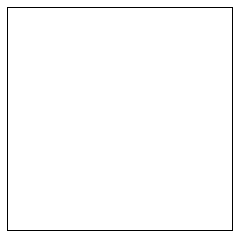

In [50]:
#Create a basemap instance with boundaries of the city we want to map 
city_bounds=np.loadtxt('/afs/cs.stanford.edu/u/tgebru/cars/ipython_code/data/cityids_bounds.txt',
                      delimiter=',')
#for city in xrange(city_bounds.size):
city=62
cityid=int(city_bounds[city,0])
ll=(city_bounds[city,4],city_bounds[city,2])
ur=(city_bounds[city,3],city_bounds[city,1])
coords=list(chain(ll,ur))
w,h=coords[2]-coords[0],coords[3]-coords[1]
extra=0.05
#The center lat, longs for the city
lon_0=0.5*(city_bounds[city,3]+city_bounds[city,4])
lat_0=0.5*(city_bounds[city,1]+city_bounds[city,2])

m = Basemap(
    projection='tmerc',
    lon_0=lon_0,
    lat_0=lat_0,
    lat_ts=0,
    llcrnrlon=coords[0],
    llcrnrlat=coords[1],
    urcrnrlon=coords[2],
    urcrnrlat=coords[3],
    ellps = 'WGS84',
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    'data/nycg_16a/nycg_4326',
    'us',
    color='none',
    zorder=2)

# set up a map dataframe
all_df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.us],
    'district': [info['CongDist'] for info in m.us_info]})

In [47]:
cityid

175

In [51]:
#Get voting results for each precinct
timelapse_dict={}
info_dir='/scail/scratch/u/tgebru/gsv_classify/analysis/demo/results/predictions'
info_file='unfiltered.Median_household_income_--total.DISTRICT.diff.1.glm.0.no.5.ni.1.\
rc.1.minp.202.minc.202.cp.1.train-2013.test-2014.whole_country.0.prev.1.manhat.0.txt'
lines=open(os.path.join(info_dir,info_file),'rb').readlines()
for l in lines:
  district=l.split(',')[0].strip()
  if 'district' in timelapse_dict:
      timelapse_dict['district'].append(int(district))
  else: 
      timelapse_dict['district']=[int(district)]
  if 'actual' in timelapse_dict:
      timelapse_dict['actual'].append(float(l.split(',')[1].strip()))
  else:
      timelapse_dict['actual'] = [float(l.split(',')[1].strip())]
  if 'predicted' in timelapse_dict:
      timelapse_dict['predicted'].append(float(l.split(',')[2].strip()))

  else:
      timelapse_dict['predicted']=[float(l.split(',')[2].strip())]

income=pd.DataFrame(timelapse_dict)
df_map = all_df_map.merge(income)

In [ ]:
class MidPointNorm(Normalize):    
    def __init__(self, midpoint=0, vmin=None, vmax=None, clip=False):
        Normalize.__init__(self,vmin, vmax, clip)
        self.midpoint = midpoint

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")       
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = ma.getmask(result)
                result = ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint            
            resdat[resdat>0] /= abs(vmax - midpoint)            
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = ma.array(resdat, mask=result.mask, copy=False)                

        if is_scalar:
            result = result[0]            
        return result

    def inverse(self, value):
        if not self.scaled():
            raise ValueError("Not invertible until scaled")
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if mpl.cbook.iterable(value):
            val = ma.asarray(value)
            val = 2 * (val-0.5)  
            val[val>0]  *= abs(vmax - midpoint)
            val[val<0] *= abs(vmin - midpoint)
            val += midpoint
            return val
        else:
            val = 2 * (val - 0.5)
            if val < 0: 
                return  val*abs(vmin-midpoint) + midpoint
            else:
                return  val*abs(vmax-midpoint) + midpoint

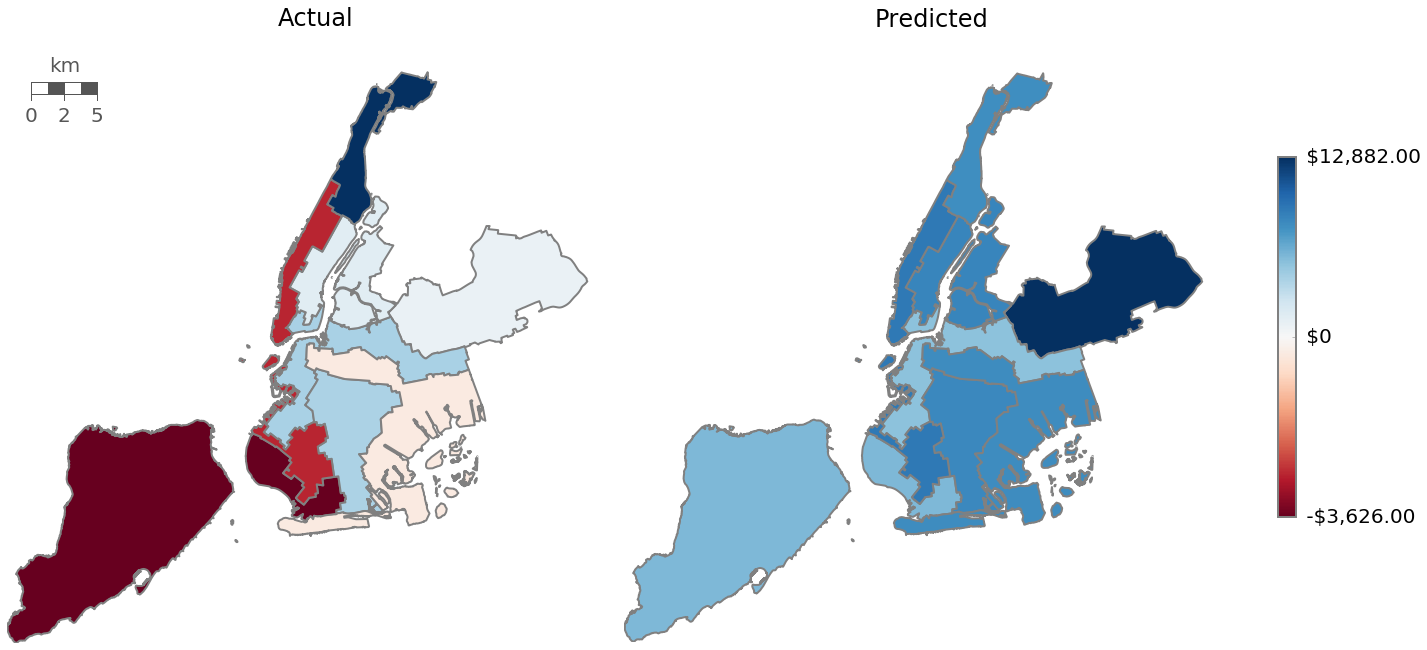

In [101]:
#Make Actual/Predicted maps with continuous colormap: no binning
plt.clf()
fig = plt.figure(figsize=(30, 10))
fig.set_size_inches(20, 10)

gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.245]) 
ax1 = fig.add_subplot(gs[0], axisbg='w', frame_on=False)

#Min and Max of data
max_label=max(max(df_map['actual'].values),max(df_map['predicted'].values))
min_label=min(min(df_map['actual'].values),min(df_map['predicted'].values)) 

#Actual Map
cmap = plt.get_cmap('RdBu')

# draw zipcodes with grey outlines
df_map['patches_act'] = df_map['poly'].map(lambda x: 
                                       PolygonPatch(x, ec='#808080', lw=2, alpha=1, zorder=4))   

pc = PatchCollection(df_map['patches_act'], match_original=True)

# impose our color map onto the patch collection


norm = MidPointNorm(midpoint=0)
pc.set_facecolor(cmap(norm(df_map['actual'].values)))
ax1.add_collection(pc)
plt.title("Actual",fontsize=24)


m.drawmapscale(
    coords[0]+0.05, coords[1]+0.38,
    coords[0], coords[1],
    5.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w',fillcolor2='#555555',
    fontcolor='#555555',
    fontsize=20,
    zorder=5)
  

m.drawmapboundary(linewidth=0)

#Predicted Map   
ax2 = fig.add_subplot(gs[1], axisbg='w', frame_on=False)
df_map['patches_pred'] = df_map['poly'].map(lambda x: 
                                       PolygonPatch(x, ec='#808080', lw=2, alpha=1, zorder=4))   
pc2 = PatchCollection(df_map['patches_pred'], match_original=True)
pc2.set_facecolor(cmap(norm(df_map['predicted'].values)))
ax2.add_collection(pc2)

# Add a colour bar
locale.setlocale( locale.LC_ALL, '' )
nlabels=3
ncolors=nlabels
labels = [" %s" % locale.currency(n, grouping=True) for n in 
          np.linspace(min_label,int(max_label),ncolors)]

labels[1]=" $0"

#labels = [" %d" %n for n in np.linspace(min_label,max_label,nlabels)]

cb = colorbar_index(ncolors=ncolors, labels=labels, discretize=False, 
                    cmap=cmap, max_label=max_label, min_label=min_label,shrink=0.5)
plt.title("Predicted",fontsize=24)
m.drawmapboundary(linewidth=0)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig('/chicago_income.png', dpi=100, alpha=True)
plt.show()